# import packages

In [1]:
#libraries and dirrectory 
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import patientFunctions as ptfn
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches


# directory management

In [2]:
#location of original data
starting_directory = os.getcwd()


machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
# machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '012 Processed Data/data-2024-06-05' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

new_dirrectory = path

os.chdir(new_dirrectory)

In [3]:
#updates to directory management
machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
# machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '015_Mistic2025' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

# parent_dir = path
outputDir = path

## naming file outputs

In [4]:
folderNameHeader = "DFsForSVM"
folderNameCommon = ""
folderNameSuffix = "_20250416"

fileNameHeader_1 = "DF_SVM_"
# fileNameHeader_2 = "ALUnknownPts"
# fileNameCommon = "_Features"
fileNameSuffix = "_20250416"

folder_data_out = ptfn.makeFolderPathForData(parent_dir=outputDir, folderName_header=folderNameHeader, 
                                        folderName_common=folderNameCommon, folderName_suffix=folderNameSuffix)


folderNameOut = folder_data_out

# Penalty scores used throughout for missing data and low time resolution

## length 1

In [5]:
#filler information for fits of 1 point
# one_point_STD = 0
one_point_r2 = -1
# one_point_residual_error = 0

## length 0

In [6]:
penalty_coef= np.nan
penalty_intercept = np.nan
penalty_R2 = np.nan
penalty_residual_error = np.nan
penalty_fillna = np.nan

In [7]:
penalty_echo = -1


# collecting patient information

In [8]:
#importing patient data as dictionaries of dataframes

#build a dictionary of patients and their values 
ptFiles = ptfn.GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

ptDict = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = ptfn.patient(new_dirrectory, file, 4)
    ptDict[pt.ptID] = pt

In [9]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRITimeColumn = 'time from dagnosis to MRI (months)'
echoDates = {}
for pt in ptDict.keys():
    ptEchoData = ptDict[pt].echoData
    patientEchoDate = ptEchoData[EchoTimeColumn]
    if 'none' not in list(patientEchoDate):
        echoDates[pt] = patientEchoDate

#test to see if this still runs and if the data is correct

# patients of interest

In [10]:
#list of patients by amyloid status 

listPositive = []
listNegative = []
listOther = []


list_pts_remove = ["K-01", "G-01", "J-01", "L-02"]
#remove list_pts_remove from ptDict
for pt in list_pts_remove:
    if pt in ptDict:
        del ptDict[pt]

#get list of positive patients 
for pt in ptDict:
    ptALStatus = ptDict[pt].amyloid_status
    if ptALStatus == 'yes':
        listPositive.append(pt)
    elif ptALStatus == 'no':
        listNegative.append(pt)
    else:
        listOther.append(pt)


In [11]:

listKnown = listPositive + listNegative

# labs of interest

labs of interest have at least one data point for each patient and aren't tagged as methods or limits of normality

In [12]:
# First cleaning the lab names while keeping 'RelTime(Days)' unchanged
cleanLabNames = [re.sub(r'\(.*?\)', '', x).replace("Result", '').replace('.', '').strip() if x != 'RelTime(Days)' else x for x in ptDict['E-01'].labsData.columns]

In [13]:
#apply the clean lab names to all patients labsData
for pt in ptDict:
    ptDict[pt].labsData.columns = cleanLabNames

In [14]:
# cleaning troponin where it is a string entry of '<0.010' or BNP has '<5' as an entry to 0
for pt in listKnown:
    ptDict[pt].labsData['Troponin-T'].replace('<0.010', 0, inplace=True)
    ptDict[pt].labsData['NT Pro BNP'].replace('<5', 0, inplace=True)


C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\3595993921.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ptDict[pt].labsData['Troponin-T'].replace('<0.010', 0, inplace=True)
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\3595993921.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [15]:
#for patient labs, convert to boolean and find the number of each lab (true)
ptLabsBool = {}
for pt in ptDict.keys():
    ptLabsData = ptDict[pt].labsData
    #convert to boolean if not nan
    ptLabsData = ptLabsData.notna() #not sure this is capturing the null data correctly
    #find the number of each lab (true)
    ptLabsData = ptLabsData.sum(axis=0) #check the axis
    #add to the dictionary describing the number of each lab the patient has
    ptLabsBool[pt] = ptLabsData

#then find frequency of labs across all patients
ptLabsBool_df = pd.DataFrame(ptLabsBool)
#count frequency of value in a column 

dict_value_counts_labs ={}
for lab in ptLabsBool_df.index:
    #call a row and perform value counts, save it to a key as the lab name in the dictionary
    dict_value_counts_labs[lab] = ptLabsBool_df.loc[lab].value_counts()

#convert to dataframe and transpose
df_value_counts_labs = pd.DataFrame(dict_value_counts_labs).T

In [16]:
#removing things that aren't lab values
omit = ['Method',"Lower Limit of Normal", "Upper Limit of Normal"]

#drop the rows whos string contains items from the omit list
df_value_counts_labs_filtered = df_value_counts_labs[~df_value_counts_labs.index.str.contains('|'.join(omit))]

#collect the rows where the column"0" is null
df_value_counts_labs_filtered = df_value_counts_labs_filtered[df_value_counts_labs_filtered[0].isnull()]

#print the index of df_value_counts_labs_filtered
filteredLabs = df_value_counts_labs_filtered.index.tolist()

In [17]:
#remove 'DeID', 'Survival(Mo)', 'RelTime(Days)', 'Unnamed: 0' from the filteredLabs list
filteredLabs = [x for x in filteredLabs if x not in ['DeID', 'Survival', 'RelTime(Days)', 'Unnamed: 0']]

In [18]:
filteredLabs

['ALT',
 'AST',
 'Albumin Electrophoresis',
 'Albumin',
 'BUN',
 'Beta-2-Microglobulin',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Glucose',
 'HCT',
 'Hemoglobin',
 'Immature Gran Auto',
 'Kappa Free Light Chains',
 'Kappa/Lambda Free Light Chain Ratio',
 'LDH',
 'Lambda Free Light Chains',
 'MCH',
 'MCHC',
 'MCV',
 'Monocyte',
 'Neutrophil',
 'Nucleated RBC',
 'Pct Immature Gran Auto',
 'Pct Mono',
 'Pct Neutrophil',
 'Platelet Count',
 'Potassium',
 'RBC',
 'Serum Electrophoresis Alpha 1',
 'Serum Electrophoresis Alpha 2',
 'Serum Electrophoresis Beta',
 'Serum Electrophoresis Gamma',
 'Sodium',
 'Total Serum Protein',
 'WBC',
 'total CO2',
 'NT Pro BNP',
 'Troponin-T']

In [19]:
list(ptDict['E-01'].labsData.columns)

['Unnamed: 0',
 'DeID',
 '5-HIAA',
 'Anisocytosis',
 'Macrocytes',
 '25 Hydroxy Vitamin D',
 'A1C',
 'ABG Base Excess',
 'ABG pH',
 'ABORh Type',
 'ALT',
 'ALT Upper Limit of Normal',
 'APTT Lower Normal Limit',
 'APTT',
 'APTT Upper Normal Limit',
 'AST',
 'AST Upper Limit of Normal',
 'Albumin Electrophoresis',
 'Albumin Lower Limit of Normal',
 'Albumin',
 'Albumin Upper Limit of Normal',
 'Amylase',
 'Amylase Upper Limit of Normal',
 'Arterial Lactic Acid',
 'Atypical Lymphocyte',
 'Atypical Lymphocyte  Method',
 'B12 Lower Normal Limit',
 'B12',
 'B12 Upper Normal Limit',
 'RelTime(Days)',
 'Survival',
 'BUN',
 'BUN Upper Limit of Normal',
 'Basophil',
 'Basophil  Method',
 'Beta-2-Microglobulin Lower Limit of Normal',
 'Beta-2-Microglobulin',
 'Beta-2-Microglobulin Upper Limit of Normal',
 'Bilirubin Lower Limit of Normal',
 'Bilirubin',
 'Bilirubin Upper Limit of Normal',
 'Blast',
 'Blast  Method',
 'CPK Lower Normal Limit',
 'CPK',
 'CPK Upper Normal Limit',
 'Calcium Cation E

In [20]:
len(filteredLabs)

39

## slice of patient data near echo or MRI date

In [21]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRITimeColumn = 'time from dagnosis to MRI (months)'
#convert the echoDates from months to days
imagingDates_days = {}
for pt in ptDict.keys():
    ptEchoData = ptDict[pt].echoData
    patientEchoDate = ptEchoData[EchoTimeColumn]
    #if the patientEchoDate is not 'none' then convert to days
    if 'none' not in list(patientEchoDate):
        ptImageDate = patientEchoDate * 30.44
        imagingDates_days[pt] = ptImageDate

    #if the patientEchoDate is 'none' then find time "time from dagnosis to MRI (months)" and convert to days
    if 'none' in list(patientEchoDate):
        patientMRIDate = ptEchoData[MRITimeColumn]
        if 'none' not in list(patientMRIDate):
            ptImageDate = patientMRIDate * 30.44
            imagingDates_days[pt] = ptImageDate

In [22]:
ptData_ImagingAdj = {}
ptDateOfLabs_imageAdj = {} #dictionary of the date of labs near imaging date
for pt in listKnown: #uses only the list of known patients
    ptLabsData = ptDict[pt].labsData
    #call the row of data where the RelTime(Days) is closest to the value of imagingDates_days[pt]
    ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
    ptDateOfLabs_imageAdj[pt] = ptLabsData_slice.at[0, 'RelTime(Days)']
    ptData_ImagingAdj[pt] = ptLabsData_slice[filteredLabs].iloc[0]  #single row

#convert to dataframe
ptData_ImagingAdj_df = pd.DataFrame.from_dict(ptData_ImagingAdj, orient='index')


C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2975035143.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2975035143.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2975035143.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_da

In [23]:
ptData_ImagingAdj_df.loc[listKnown]

,ALT,AST,Albumin Electrophoresis,Albumin,BUN,Beta-2-Microglobulin,Calcium,Chloride,Creatinine,Glucose,...,Serum Electrophoresis Alpha 1,Serum Electrophoresis Alpha 2,Serum Electrophoresis Beta,Serum Electrophoresis Gamma,Sodium,Total Serum Protein,WBC,total CO2,NT Pro BNP,Troponin-T
B-02,19.0,14.0,3.9,4.1,39.0,18.1,9.0,101.0,8.3,101.0,...,0.4,0.7,0.5,0.4,142.0,5.9,16.24,24.0,611.0,0.015
C-03,69.0,102.0,3.0,2.8,35.0,12.0,8.9,105.0,2.5,84.0,...,0.5,1.4,1.0,0.5,141.0,6.4,10.00,22.0,3321.0,0.492
E-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.79,NaN,NaN,NaN
E-02,28.0,22.0,2.9,2.4,34.0,7.5,8.4,99.0,3.9,167.0,...,0.3,1.5,0.6,0.2,136.0,5.5,8.69,21.0,9328.0,0.088
F-03,7.0,12.0,4.3,4.1,29.0,3.8,9.5,101.0,1.3,91.0,...,0.3,0.9,0.9,1.3,139.0,7.7,3.54,27.0,166.0,0.000
G-02,13.0,14.0,2.7,3.2,11.0,4.0,9.5,104.0,1.1,95.0,...,0.6,1.2,0.6,0.3,142.0,5.3,6.48,22.0,5928.0,0.086
I-01,19.0,29.0,2.2,1.9,10.0,2.5,8.5,101.0,0.8,104.0,...,0.3,1.5,0.7,0.3,139.0,5.0,7.34,28.0,309.0,0.000
I-03,24.0,30.0,51.4,1.8,16.0,2.6,8.2,107.0,1.2,84.0,...,4.8,22.4,14.0,7.4,141.0,3.8,5.12,27.0,314.0,0.000
J-02,60.0,38.0,4.0,4.0,9.0,2.5,9.3,96.0,0.8,95.0,...,0.5,0.8,0.7,1.7,133.0,7.7,7.02,22.0,9293.0,0.019
K-02,10.0,22.0,2.9,3.0,47.0,8.0,9.3,104.0,3.5,94.0,...,0.3,0.8,1.5,0.8,142.0,6.3,9.44,24.0,10432.0,0.102


Text(0.5, 1.0, 'Completeness of Imaging Adjacent Labs before replacement \n 1 =complete, 0=missing')

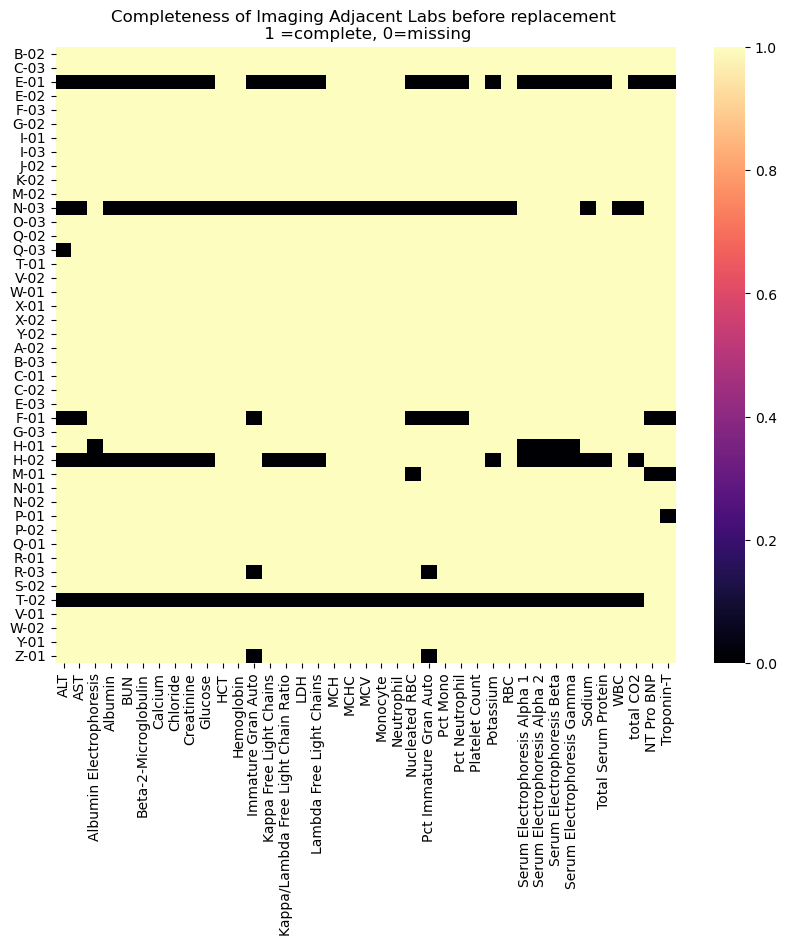

In [24]:
# Event plot of the completeness of the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot patients in listPositive with plasma colormap
sns.heatmap(ptData_ImagingAdj_df.loc[listKnown].notna(), cbar=True, cmap= 'magma',
            yticklabels=ptData_ImagingAdj_df.loc[listKnown].index, ax=ax)
plt.title("Completeness of Imaging Adjacent Labs before replacement \n 1 =complete, 0=missing")

In [25]:

#replace missing values in ptData_ImagingAdj_df with echo penality score
ptData_ImagingAdj_df = ptData_ImagingAdj_df.fillna(penalty_echo)


In [26]:
ptData_ImagingAdj_df.loc[listKnown]

,ALT,AST,Albumin Electrophoresis,Albumin,BUN,Beta-2-Microglobulin,Calcium,Chloride,Creatinine,Glucose,...,Serum Electrophoresis Alpha 1,Serum Electrophoresis Alpha 2,Serum Electrophoresis Beta,Serum Electrophoresis Gamma,Sodium,Total Serum Protein,WBC,total CO2,NT Pro BNP,Troponin-T
B-02,19.0,14.0,3.9,4.1,39.0,18.1,9.0,101.0,8.3,101.0,...,0.4,0.7,0.5,0.4,142.0,5.9,16.24,24.0,611.0,0.015
C-03,69.0,102.0,3.0,2.8,35.0,12.0,8.9,105.0,2.5,84.0,...,0.5,1.4,1.0,0.5,141.0,6.4,10.00,22.0,3321.0,0.492
E-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.79,-1.0,-1.0,-1.000
E-02,28.0,22.0,2.9,2.4,34.0,7.5,8.4,99.0,3.9,167.0,...,0.3,1.5,0.6,0.2,136.0,5.5,8.69,21.0,9328.0,0.088
F-03,7.0,12.0,4.3,4.1,29.0,3.8,9.5,101.0,1.3,91.0,...,0.3,0.9,0.9,1.3,139.0,7.7,3.54,27.0,166.0,0.000
G-02,13.0,14.0,2.7,3.2,11.0,4.0,9.5,104.0,1.1,95.0,...,0.6,1.2,0.6,0.3,142.0,5.3,6.48,22.0,5928.0,0.086
I-01,19.0,29.0,2.2,1.9,10.0,2.5,8.5,101.0,0.8,104.0,...,0.3,1.5,0.7,0.3,139.0,5.0,7.34,28.0,309.0,0.000
I-03,24.0,30.0,51.4,1.8,16.0,2.6,8.2,107.0,1.2,84.0,...,4.8,22.4,14.0,7.4,141.0,3.8,5.12,27.0,314.0,0.000
J-02,60.0,38.0,4.0,4.0,9.0,2.5,9.3,96.0,0.8,95.0,...,0.5,0.8,0.7,1.7,133.0,7.7,7.02,22.0,9293.0,0.019
K-02,10.0,22.0,2.9,3.0,47.0,8.0,9.3,104.0,3.5,94.0,...,0.3,0.8,1.5,0.8,142.0,6.3,9.44,24.0,10432.0,0.102


Text(0.5, 1.0, 'Completeness of Imaging Adjacent Labs after replacement \n 1 =complete, 0=missing')

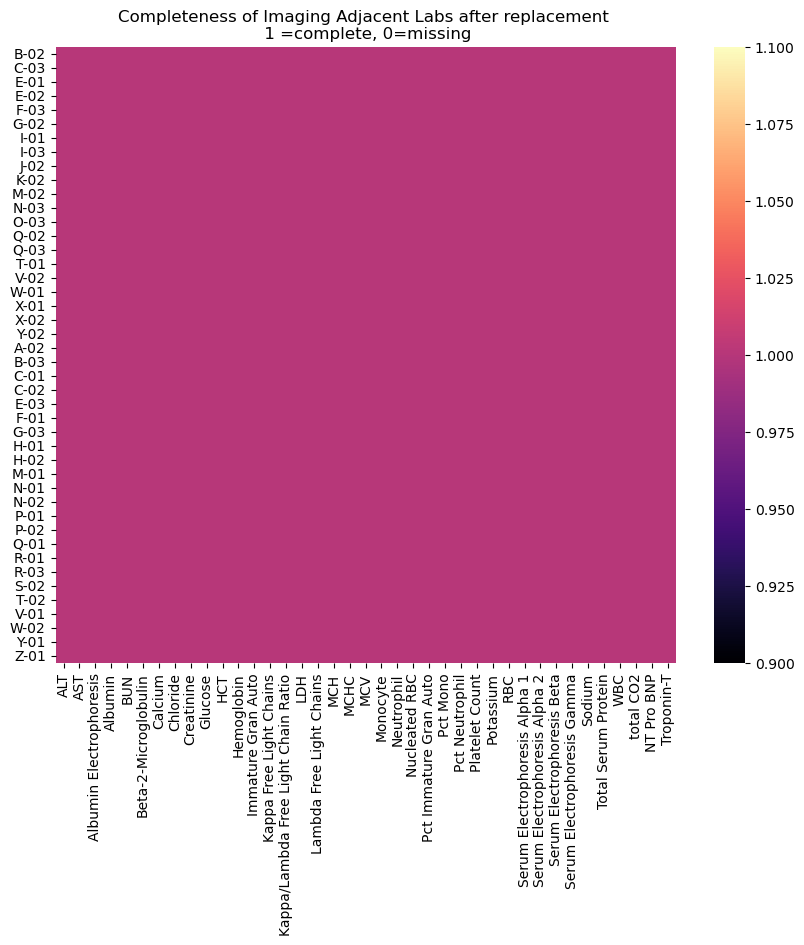

In [27]:
# Event plot of the completeness of the data
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(ptData_ImagingAdj_df.loc[listKnown].notna(), cbar=True, cmap= 'magma',
            yticklabels=ptData_ImagingAdj_df.loc[listKnown].index, ax=ax)
plt.title("Completeness of Imaging Adjacent Labs after replacement \n 1 =complete, 0=missing")


### timing of labs and imaging
collecting the timing of the labs and imaging in days for comparison

In [28]:
#convert imagingDates_days to dataframe
imagingDates_days_df = pd.DataFrame.from_dict(imagingDates_days, orient='index')
imagingDates_days_df.columns = ['ImagingDate']
#convert ptdateoflabs_imageAdj to dataframe 
ptDateOfLabs_imageAdj_df = pd.DataFrame.from_dict(ptDateOfLabs_imageAdj, orient='index', columns=['LabsDate'])
#concatenate the two dataframes
imagingAndLabDates_df = pd.concat([imagingDates_days_df, ptDateOfLabs_imageAdj_df], axis=1)
#reset the index to be the patient ID   
imagingAndLabDates_df.index.name = 'DeID'
imagingAndLabDates_df['timeDelta'] = imagingAndLabDates_df['LabsDate'] - imagingAndLabDates_df['ImagingDate'] if imagingAndLabDates_df['LabsDate'] is not None else np.nan

In [29]:
imagingAndLabDates_df.loc[listKnown]

,ImagingDate,LabsDate,timeDelta
DeID,,,
B-02,134.950667,9.0,-125.950667
C-03,-1.014667,-2.0,-0.985333
E-01,659.533333,-2211.0,-2870.533333
E-02,63.924000,108.0,44.076000
F-03,614.888000,1312.0,697.112000
G-02,133.936000,11.0,-122.936000
I-01,34.498667,-11.0,-45.498667
I-03,49.718667,20.0,-29.718667
J-02,27.396000,27.0,-0.396000


# encoding demographic information

In [30]:
#collect age, sex, and dx and make it lowercase
#make a dictionary of patient demographics
ptSex, ptDx, ptALStatus = {}, {}, {}

for pt in ptDict.keys():
    ptSex[pt] = ptDict[pt].sex.lower()
    # ptAge[pt] = ptDict[pt].ageDx
    ptDx[pt] = ptDict[pt].dx
    ptDx[pt] = re.sub(r"[\\/\d]", "", ptDx[pt]).lower()
    ptALStatus[pt] = ptDict[pt].amyloid_status.lower()

    
    #Convert "multiple myeloma" to "MM"
    ptDx[pt] = ptDx[pt].replace("multiple myeloma", "mm")
    #still have compound entries
    # if ptDx[pt] contains "mg" replace the entry with "mgus", if contains "mm" replace with "mm"
    if "mg" in ptDx[pt]:
        ptDx[pt] = "mgus"
    elif "mm" in ptDx[pt]:
        ptDx[pt] = "mm"
    elif "mm" or "mg" not in ptDx[pt]:
        ptDx[pt] = 'other'

#convert the dictionaries to dataframes and concatenate them
ptSex_df = pd.DataFrame.from_dict(ptSex, orient='index', columns=['sex'])
ptALStatus_df = pd.DataFrame.from_dict(ptALStatus, orient='index', columns=['CA_status'])
ptDx_df = pd.DataFrame.from_dict(ptDx, orient='index', columns=['dx'])

#use get dummies for the Sex, ALStatus, and Dx columns.  Converting True to 1 and False to 0
ptSex_df = pd.get_dummies(ptSex_df, dtype = int).drop("sex_male", axis = 1) #dropping male column to prevent dummy variable trap in SVM
ptDx_df = pd.get_dummies(ptDx_df, dtype = int).drop("dx_other", axis = 1) #three dx codes, dropping the other column to prevent drummy trapping

ptALStatus_df = pd.get_dummies(ptALStatus_df, dtype = int).drop(["CA_status_unk"], axis = 1) 
#keeping two columns for now, so that the unknown patients can still be used
#drop the "CA_status_no" when parsing the data for SVM

#concatenate the dataframes
ptDemographics_df = pd.concat([ptALStatus_df, ptSex_df, ptDx_df], axis=1)

In [31]:
#collecting age and survival data
ptAge, ptsurvival = {}, {}
for pt in ptDict.keys():
    ptAge[pt] = ptDict[pt].ageDx
    ptsurvival[pt] = ptDict[pt].survival

#convert to dataframe
ptAge_df = pd.DataFrame.from_dict(ptAge, orient ='index', columns = ['age'])
ptsurvival_df = pd.DataFrame.from_dict(ptsurvival, orient = 'index', columns = ['survival(mo)'])
#concatenate the dataframes
ptDemographics_df = pd.concat([ptDemographics_df, ptAge_df, ptsurvival_df],
                               axis=1)
#rename the columns


In [32]:
ptDemographics_df

,CA_status_no,CA_status_yes,sex_female,dx_mgus,dx_mm,age,survival(mo)
A-02,1,0,1,1,0,74,7.266667
A-03,0,0,1,0,1,71,5.000000
B-01,0,0,1,0,0,57,243.000000
B-02,0,1,0,1,0,48,9.466667
B-03,1,0,0,0,1,43,18.000000
...,...,...,...,...,...,...,...
X-02,0,1,0,1,0,63,38.233333
Y-01,1,0,0,0,1,59,40.000000
Y-02,0,1,1,1,0,57,12.766667
Z-01,1,0,1,0,0,72,2.000000


# encoding note information

In [33]:
#dictionaries for conversion
dictECOGtoKPS = {0 : 95,
                 1 : 75, 
                 2 : 55, 
                 3 : 35, 
                 4 : 15, 
                 5 : 0}

dictKPStoECOG = {100: 0, 90: 0, 
                 80: 1, 70: 1, 
                 60: 2, 50: 2, 
                 40: 3 , 30: 3, 
                 20: 4, 10: 4, 0: 5 }

ptDictMDnotesScored = {}
#loop through the listOfPatients
for pt in ptDict.keys():
    #call each patient in the dictionary storing patient note information
    ptNotes = ptDict[pt].MDnotes

    if not isinstance(ptNotes, bool):

        #columns of interest
        listColumnNames = ['time from diagnosis to note (months)', 'ECOG Performance Status', 'Karnofsky Performance Status']
        ptNotesCorrected = ptNotes[listColumnNames]
        #convert the Karnofsky scores to integers
        ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)

        #remove rows where the "ECOG Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['ECOG Performance Status'] != 'OTHER'] 
        #remove rows where the "Karnofsky Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['Karnofsky Performance Status'] != 'OTHER']

        # old methods, we will see if we still need this

        for i in list(ptNotesCorrected.index):
            #get the scores for that row
            ptTime = ptNotesCorrected.at[i, 'time from diagnosis to note (months)']
            ptECOG = ptNotesCorrected.at[i,'ECOG Performance Status']
            ptKPS = ptNotesCorrected.at[i, 'Karnofsky Performance Status']
        
            #if the value of ptECOG was "OTHER", then the row should be dropped.
            if ptECOG == "OTHER":
                # ptNotesCorrected.drop(index = i, inplace=True ) #drops the full row, would need to add time back if interested in clinical impression
                ptECOG = np.nan #replacement is dropped before descriptive stats are run
                ptKPS = np.nan #replacement is dropped before descriptive stats are run

            #infer ECOG from Karnofsky where you now have half points
            elif np.isnan(ptECOG) ==True and pd.isna(ptKPS) == False: 
                ptECOG = dictKPStoECOG[ptKPS]

            #infer Karnofsky from ECOG 
            elif pd.isna(ptKPS) == True and np.isnan(ptECOG) ==False: 
                ptKPS = dictECOGtoKPS[ptECOG]

            #save these values back to the dataframe
            if ptECOG != "OTHER":
                ptNotesCorrected.at[i,'ECOG Performance Status'] = ptECOG
                ptNotesCorrected.at[i, 'Karnofsky Performance Status'] = ptKPS
                                
    #saving the notes to the new dictionary
    ptDictMDnotesScored[pt] = ptNotesCorrected


<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2233743332.py:27: SyntaxWarning: invalid escape sequence '\d'
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2233743332.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)
C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\2233743332.py:27: SettingWithCopyWarning: 
A value is trying to be set on a cop

# descriptive stats for each lab by patient
don't forget to handle instances of 1 for values which aren't counts to be the one recorded value

In [34]:
#descriptive statistics for each lab for each patient and assign to a dictionary
ptLabsDescriptiveStats = {}
#loop through the list of known patients
for pt in listKnown:
    #call each patient in the dictionary storing patient lab information
    ptLabs = ptDict[pt].labsData[filteredLabs] #instead call the filtered labs situation
    #get the descriptive statistics for the labs
    ptLabsDescriptiveStats_calc = ptLabs[filteredLabs].describe()
    ptLabsDescriptiveStats_calc['stats'] = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    #when the count of data is 1, then use the value of the lab as the std
    for lab in filteredLabs:
        if ptLabsDescriptiveStats_calc[lab]['count'] == 1:
            ptLabsDescriptiveStats_calc[lab]['std'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['min'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['25%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['50%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['75%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['max'] = ptLabsDescriptiveStats_calc[lab]['mean']
    
    #drop the count information
    ptLabsDescriptiveStats_calc.drop('count', axis=0, inplace=True)
    #melt dataframe to long format 
    ptLabsDescriptiveStats_melt = ptLabsDescriptiveStats_calc[filteredLabs].T.stack(future_stack=True) 

    ptLabsDescriptiveStats[pt] = ptLabsDescriptiveStats_melt 

#convert to dataframe
ptLabsDescriptiveStats_df = pd.DataFrame(ptLabsDescriptiveStats).T #each row is a patient
# flattens the multiindex columns into a single index with underscore as delimiter
ptLabsDescriptiveStats_df.columns = ['_'.join(col).strip() for col in ptLabsDescriptiveStats_df.columns.values] 



C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\1636947777.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ptLabsDescriptiveStats_calc[lab]['std'] = ptLabsDescriptiveStats_calc[lab]['mean']
C:\Users\mcremer\AppData\Local\Temp\ipykern

## descriptive stats of notes information

In [35]:
ptNotesDescriptiveStats = {}
noteColumns = ["ECOG Performance Status", "Karnofsky Performance Status"]
for pt in listKnown:
    ptNotes = ptDictMDnotesScored[pt][noteColumns].astype(float)
    #get the descriptive statistics for the notes
    ptNotesDescriptiveStats_calc = ptNotes.describe()
    ptNotesDescriptiveStats_calc['stats'] = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    #when the count of data is 1, then use the value of the lab as the std
    for lab in noteColumns:
        if ptNotesDescriptiveStats_calc[lab]['count'] == 1:
            ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['min'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['25%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['50%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['75%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['max'] = ptNotesDescriptiveStats_calc[lab]['mean']
    #drop the count information
    ptNotesDescriptiveStats_calc.drop('count', axis=0, inplace=True)
    #melt to long format
    ptNotesDescriptiveStats_melt = ptNotesDescriptiveStats_calc[noteColumns].T.stack(future_stack=True)
    ptNotesDescriptiveStats[pt] = ptNotesDescriptiveStats_melt

#make to dataframe
ptNotesDescriptiveStats_df = pd.DataFrame(ptNotesDescriptiveStats).T #each row is a patient
# flattens the multiindex columns into a single index with underscore as delimiter
ptNotesDescriptiveStats_df.columns = ['_'.join(col).strip() for col in ptNotesDescriptiveStats_df.columns.values]

C:\Users\mcremer\AppData\Local\Temp\ipykernel_6404\738149107.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
C:\Users\mcremer\AppData\Local\Temp\ipyker

# treatment information

In [36]:
#collect the number of treatments of different types a patient has recieved

listTxNames = ['ChemoTx', 'HematologicTx', 'RadiationTx', 'ImmunoTx', 'OtherTx']
ptTxRecievedDict = {}
for pt in listKnown:
    # ptTxRecieved = ptDict[pt].txRecieved
    ptChemoLen= len(ptDict[pt].ChemoTx) if type(ptDict[pt].ChemoTx) != bool else 0
    ptHemoLen= len(ptDict[pt].HemeTx) if type(ptDict[pt].HemeTx) != bool else 0
    ptRadLen= len(ptDict[pt].RadTx) if type(ptDict[pt].RadTx) != bool else 0
    ptImmunoLen= len(ptDict[pt].ImmunoTx) if type(ptDict[pt].ImmunoTx) != bool else 0
    ptOtherLen= len(ptDict[pt].OtherTx) if type(ptDict[pt].OtherTx) != bool else 0

    #make a list from these values
    ptTxRecievedList = [ptChemoLen, ptHemoLen, ptRadLen, ptImmunoLen, ptOtherLen]

    #add to dictionary
    ptTxRecievedDict[pt] = ptTxRecievedList

#convert to dataframe
ptTxRecieved_df = pd.DataFrame.from_dict(ptTxRecievedDict, orient='index', columns=listTxNames)
ptTxRecieved_df_dummies = pd.get_dummies(ptTxRecieved_df.replace(0,np.nan).notna().astype('category'), dtype=int, drop_first=True)
ptTxRecieved_df = pd.concat([ptTxRecieved_df, ptTxRecieved_df_dummies], axis=1)

# fits of data
look in old code to see if there are better ways of writing it.

In [37]:
#definitions of functions 

def linear_model_force(x, a):
    return a * x 


In [38]:
def prepDataForFit(dataframe, time, dataColumn, transform = ["none"]):
    dataValues =dataframe[[time, dataColumn]] #collect the data

    #clean data for null or 0 data and remove any negative y values
    #negative y values are not physiologic
    if transform == ["none"]:
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        baseline = y_values.iloc[0]
        y_values_shift = y_values - baseline
    elif transform == ["ln"]:
        # ln tranform can't handle 0 values
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        dataValues[dataColumn] = [value + 1 for value in dataValues[dataColumn]]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        y_values_transformed = np.log(y_values)
        baseline = y_values_transformed.iloc[0]
        y_values_shift = y_values_transformed - baseline

    datalength = len(y_values_shift)

    return x_values, y_values_shift, baseline, datalength


In [39]:
#linear model fits using scipy curve_fit where the intercept is the first value
def linear_model_fit(x, y, baseline, datalength):
    if datalength >1:
        #fit the data to a linear model using scipy curve_fit
        popt, pcov = curve_fit(linear_model_force, x, y)
        #get the slope and intercept from the popt array
        coef = popt[0]
        intercept = baseline

        #test predictions
        y_prediction = linear_model_force(x, coef)

        #calculate the mean squared error
        mse = mean_squared_error(y, y_prediction)
        #calculate the coeficient of determination of the fit
        r2 = r2_score(y, y_prediction)
    if datalength  ==1: 
        #if the data length is 1, then set slope to 0, set the baseline to the intercept
        coef = 0
        intercept = baseline
        #now fit the prediction
        y_prediction = linear_model_force(x, coef)
        mse = baseline
        r2 = one_point_r2

    return coef, intercept, mse, r2, y_prediction


## fits labs

In [40]:
#performing the linear fit of lab data 
ptLabsLinFitsDict = {}
for pt in listKnown:
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["none"])
        x_values_flat = x_values.squeeze()
        y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptLabsLinFitsDict[pt] = ptLabsFits


In [41]:
#convert dictionary of dataframes into single dataframe
ptLabsLinFits_df = pd.concat(ptLabsLinFitsDict.values(), axis=0, ignore_index=False)
ptLabsLinFits_df.index = ptLabsLinFitsDict.keys()

In [42]:
#performing the exponential fits of the lab data
#first transplate data by 1 to correct for 0, then transform using LN, then fit to a linear model
ptLabsExpFitsDict = {}
for pt in listKnown:
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"])
        x_values_flat = x_values.squeeze()
        y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_exp_coef': [coef],
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})], axis = 1)
        i +=1
    ptLabsExpFitsDict[pt] = ptLabsFits

In [43]:
#convert dictionary of dataframes into single dataframe
ptLabsExpFits_df = pd.concat(ptLabsExpFitsDict.values(), axis=0, ignore_index=False)
ptLabsExpFits_df.index = ptLabsExpFitsDict.keys()

## fits for the note data

In [44]:
#performing the linear fit of lab data 
ptNotesLinFitsDict = {}
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in listKnown:
    i = 0
    for lab in noteColumns:
        ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
        x_values, y_values_shift, baseline, datalength = prepDataForFit(ptNotesData, noteTimeColumn, lab, transform = ["none"])
        x_values_flat = x_values.squeeze()
        y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
        #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
        if i ==0: 
            ptNotesFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptNotesLinFitsDict[pt] = ptNotesFits



In [45]:
#convert dictionary of dataframes into single dataframe
ptNotesLinFits_df = pd.concat(ptNotesLinFitsDict.values(), axis=0, ignore_index=False)
ptNotesLinFits_df.index = ptNotesLinFitsDict.keys()

In [46]:
#performing the linear fit of lab data 
ptNotesExpFitsDict = {}
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in listKnown:
    i = 0
    for lab in noteColumns:
        ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
        x_values, y_values_shift, baseline, datalength = prepDataForFit(ptNotesData, noteTimeColumn, lab, transform = ["ln"])
        x_values_flat = x_values.squeeze()
        y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
        #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
        if i ==0: 
            ptNotesFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})
        else:
            ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_exp_coef': [coef],
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})], axis = 1)
        i +=1
    ptNotesExpFitsDict[pt] = ptNotesFits



In [47]:
#convert dictionary of dataframes into single dataframe
ptNotesExpFits_df = pd.concat(ptNotesExpFitsDict.values(), axis=0, ignore_index=False)
ptNotesExpFits_df.index = ptNotesExpFitsDict.keys()

# compile the dataframes for use in SVM 

In [48]:
#compiling for the EchoAdj labs 

#concatinate the echoadjacent labs with the demographics data
features_ImagingAdj_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptData_ImagingAdj_df], axis=1)

#renaming axis "DeID"
features_ImagingAdj_df.index.name = 'DeID'

#getting only the known patients 
features_ImagingAdj_df_knownpts = features_ImagingAdj_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column
#set index to DeID

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_ImagingAdj_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

#when exporting the data cut by CA status, convert the penalty score to nan for easy import to graphpad for stats

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_ImagingAdj_df_knownpts.loc[listPositive].replace(-1, np.nan))
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_ImagingAdj_df_knownpts.loc[listNegative].replace(-1, np.nan))

#the imaging dates
# imagingAndLabDates_df
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DatesPostiive', df_data = imagingAndLabDates_df.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DatesNegative', df_data = imagingAndLabDates_df.loc[listNegative])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DateKnown', df_data = imagingAndLabDates_df.loc[listKnown])

In [49]:
features_ImagingAdj_df_knownpts


,CA_status_yes,sex_female,dx_mgus,dx_mm,age,survival(mo),ChemoTx,HematologicTx,RadiationTx,ImmunoTx,...,Serum Electrophoresis Alpha 1,Serum Electrophoresis Alpha 2,Serum Electrophoresis Beta,Serum Electrophoresis Gamma,Sodium,Total Serum Protein,WBC,total CO2,NT Pro BNP,Troponin-T
DeID,,,,,,,,,,,,,,,,,,,,,
B-02,1,0,1,0,48,9.466667,0.0,0.0,0.0,0.0,...,0.4,0.7,0.5,0.4,142.0,5.9,16.24,24.0,611.0,0.015
C-03,1,1,0,1,59,17.000000,2.0,0.0,0.0,0.0,...,0.5,1.4,1.0,0.5,141.0,6.4,10.00,22.0,3321.0,0.492
E-01,1,0,1,0,50,71.300000,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.79,-1.0,-1.0,-1.000
E-02,1,0,1,0,64,20.466667,0.0,0.0,0.0,0.0,...,0.3,1.5,0.6,0.2,136.0,5.5,8.69,21.0,9328.0,0.088
F-03,1,0,0,1,61,52.000000,4.0,1.0,0.0,0.0,...,0.3,0.9,0.9,1.3,139.0,7.7,3.54,27.0,166.0,0.000
G-02,1,1,0,1,36,30.000000,0.0,0.0,0.0,0.0,...,0.6,1.2,0.6,0.3,142.0,5.3,6.48,22.0,5928.0,0.086
I-01,1,1,0,1,55,33.000000,4.0,0.0,0.0,2.0,...,0.3,1.5,0.7,0.3,139.0,5.0,7.34,28.0,309.0,0.000
I-03,1,0,1,0,67,10.033333,0.0,0.0,0.0,0.0,...,4.8,22.4,14.0,7.4,141.0,3.8,5.12,27.0,314.0,0.000
J-02,1,1,0,1,68,26.000000,1.0,0.0,0.0,1.0,...,0.5,0.8,0.7,1.7,133.0,7.7,7.02,22.0,9293.0,0.019


In [50]:
#compiling for descOnly

#concatinate the echoadjacent labs with the demographics data
features_DescOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptNotesDescriptiveStats_df], axis=1)

#renaming axis "DeID"
features_DescOnly_df.index.name = 'DeID'

#getting only the known patients 
features_DescOnly_df_knownpts = features_DescOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescOnly_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescOnly_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescOnly_df_knownpts.loc[listNegative])

In [51]:
#compiling for params only

#concatinate the echoadjacent labs with the demographics data
features_ParamsOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsLinFits_df, ptLabsExpFits_df, ptNotesLinFits_df, ptNotesExpFits_df], axis=1)

#renaming axis "DeID"
features_ParamsOnly_df.index.name = 'DeID'

#getting only the known patients 
features_ParmasOnly_df_knownpts = features_ParamsOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_ParmasOnly_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "ParamsOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_ParmasOnly_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_ParmasOnly_df_knownpts.loc[listNegative])

In [52]:
#compiling for Descriptive stats and fits

#concatinate the echoadjacent labs with the demographics data
features_DescFits_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptLabsLinFits_df, ptLabsExpFits_df, ptNotesDescriptiveStats_df, ptNotesLinFits_df, ptNotesExpFits_df], axis=1)

#renaming axis "DeID"
features_DescFits_df.index.name = 'DeID'

#getting only the known patients 
features_DescFits_df_knownpts = features_DescFits_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescFits_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescFits_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescFits_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescFits_df_knownpts.loc[listNegative])

# data visualizations

## completeness of the dataframes

Text(0.5, 1.0, 'Completeness of EchoAdj DF for SVM \n 1 =complete, 0=missing')

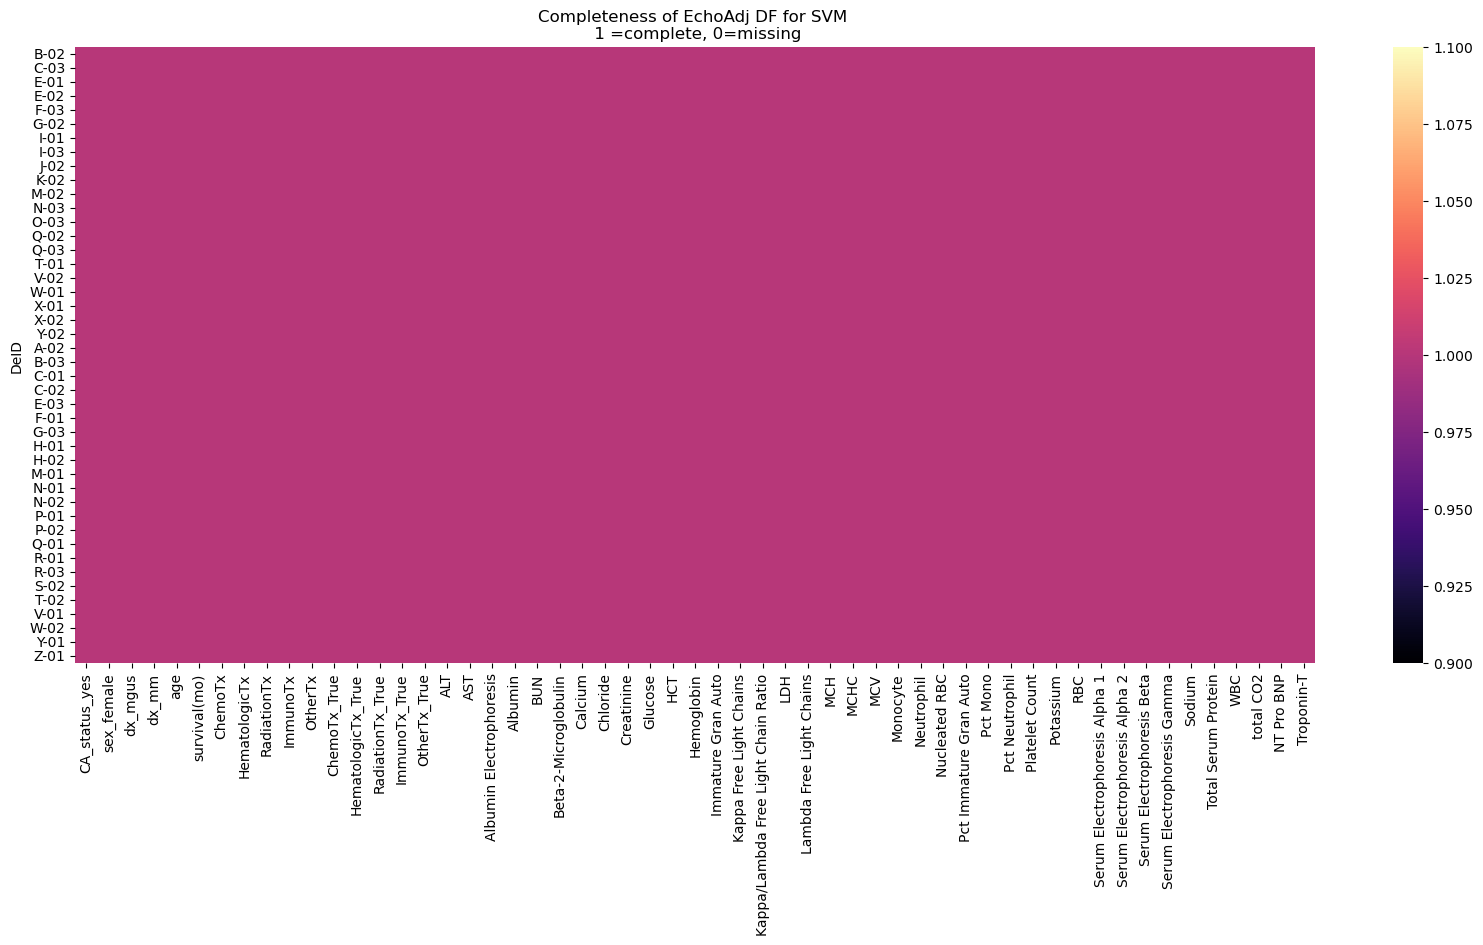

In [53]:
# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_ImagingAdj_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_ImagingAdj_df_knownpts.index, ax=ax)
plt.title("Completeness of EchoAdj DF for SVM \n 1 =complete, 0=missing")
# features_ImagingAdj_df_knownpts

Text(0.5, 1.0, 'Completeness of EchoAdj DF for SVM without Replacements \n 1 =complete, 0=missing')

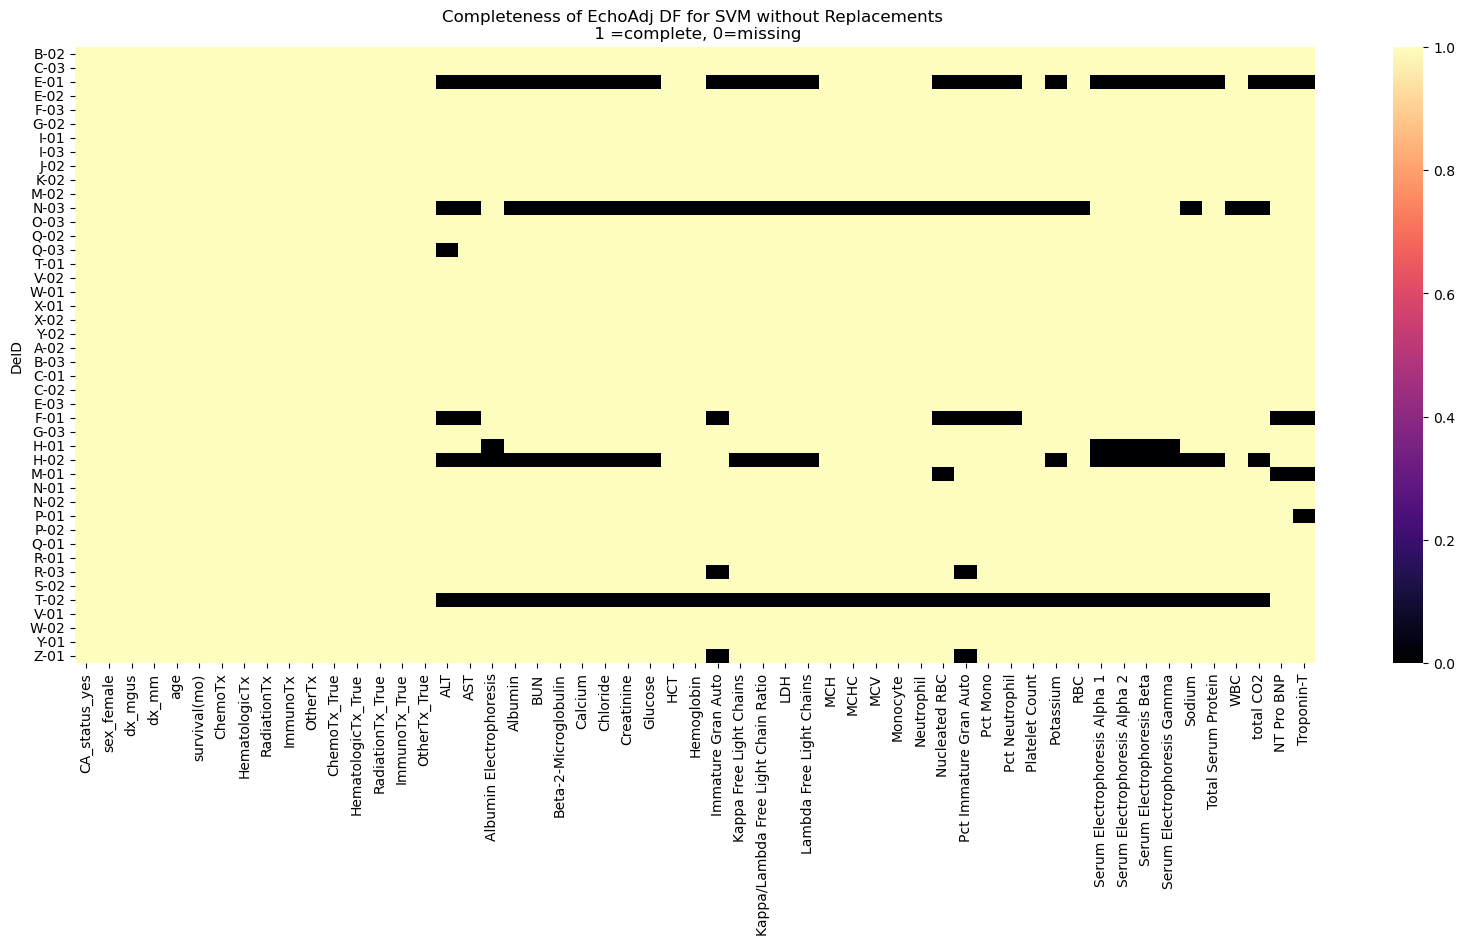

In [54]:
# heat map for features without the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_ImagingAdj_df_knownpts.replace(-1, np.nan).notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_ImagingAdj_df_knownpts.index, ax=ax)
plt.title("Completeness of EchoAdj DF for SVM without Replacements \n 1 =complete, 0=missing")
# features_ImagingAdj_df_knownpts

Text(0.5, 1.0, 'Completeness of DescOnly DF for SVM \n 1 =complete, 0=missing')

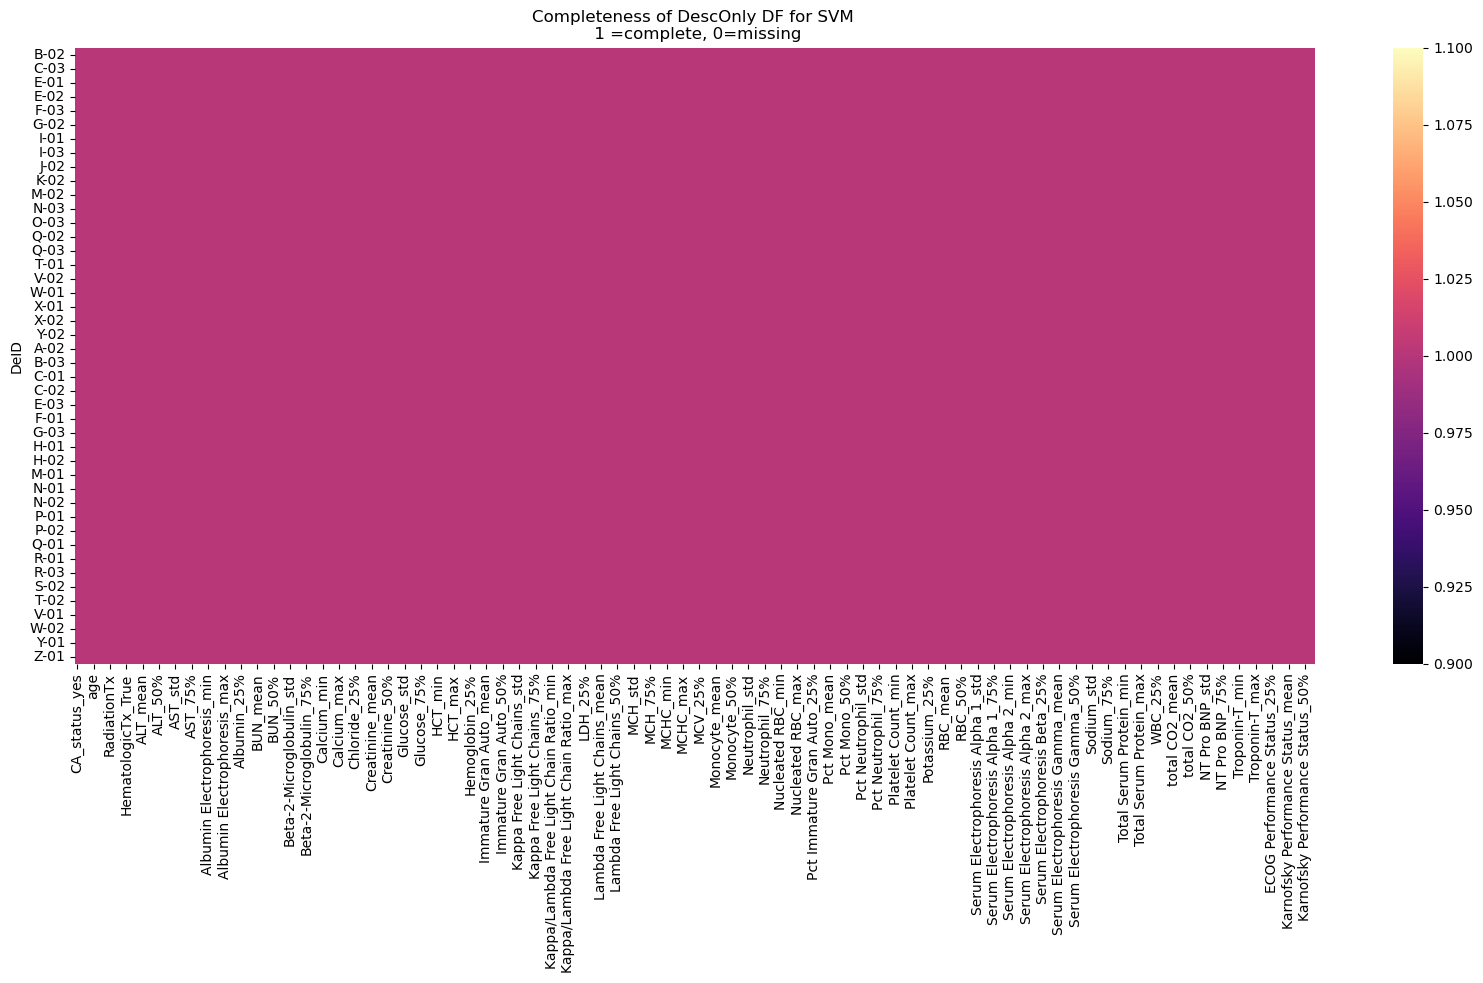

In [55]:
# features_DescOnly_df_knownpts

# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_DescOnly_df_knownpts.notna(), cbar=True, cmap= 'magma', # linecolor= 'white', linewidths=0.5,
            yticklabels=features_DescOnly_df_knownpts.index, ax=ax)
plt.title("Completeness of DescOnly DF for SVM \n 1 =complete, 0=missing")


Text(0.5, 1.0, 'Completeness of ParamsOnly DF for SVM \n 1 =complete, 0=missing')

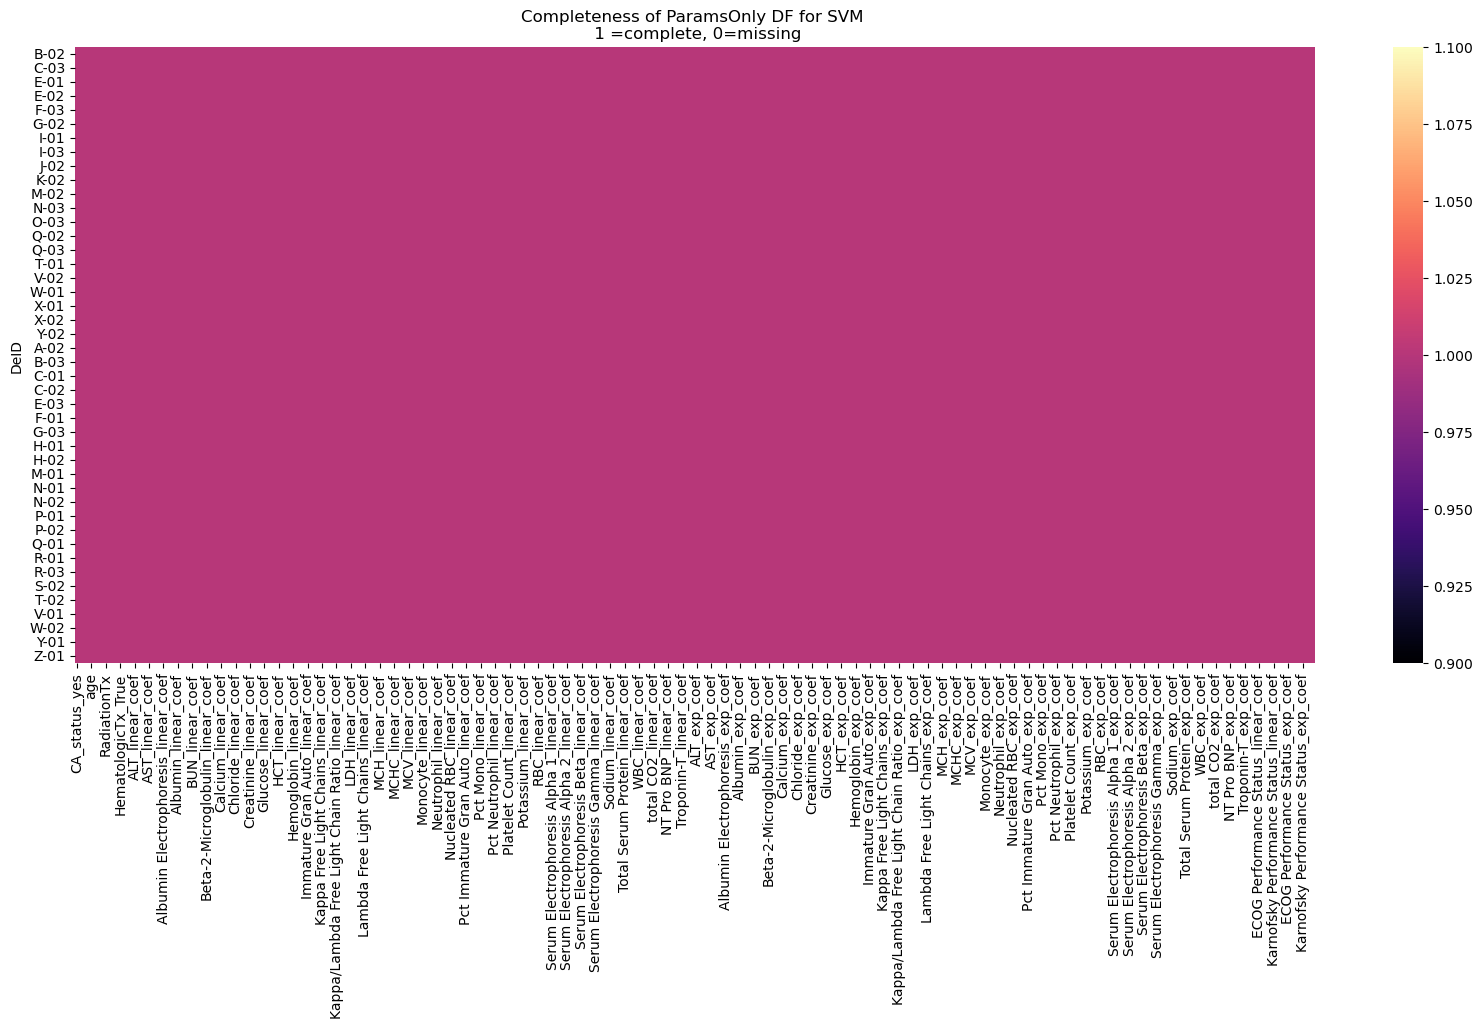

In [56]:
# features_ParmasOnly_df_knownpts

# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_ParmasOnly_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_ParmasOnly_df_knownpts.index, ax=ax)
plt.title("Completeness of ParamsOnly DF for SVM \n 1 =complete, 0=missing")


Text(0.5, 1.0, 'Completeness of DescFits DF for SVM \n 1 =complete, 0=missing')

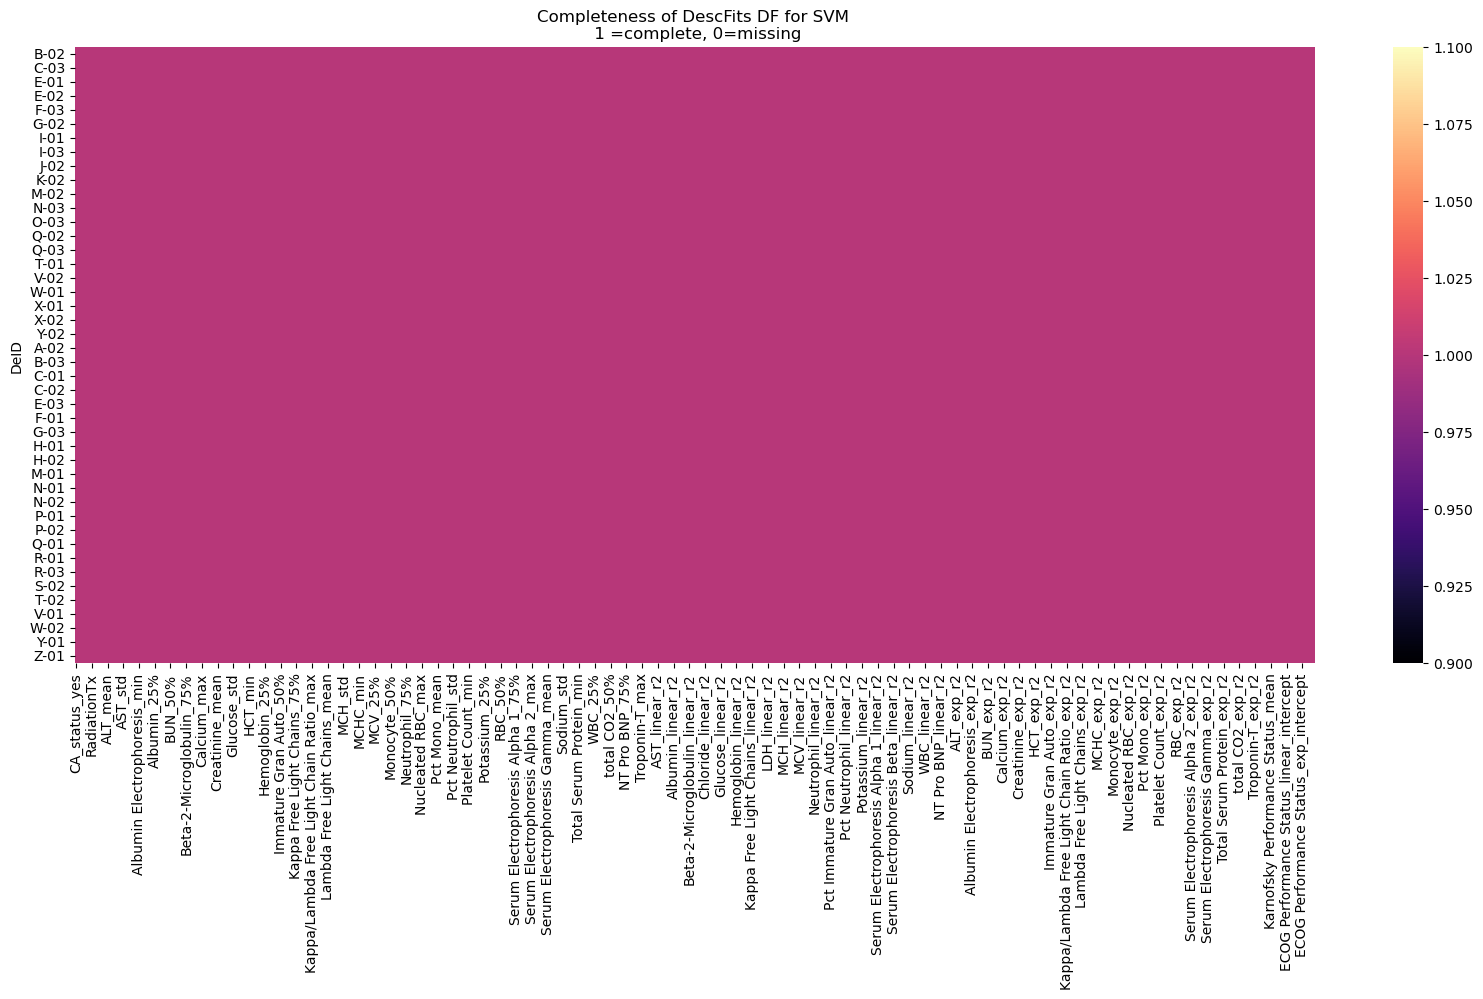

In [57]:
# features_DescFits_df_knownpts

# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_DescFits_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_DescFits_df_knownpts.index, ax=ax)
plt.title("Completeness of DescFits DF for SVM \n 1 =complete, 0=missing")


## event plots of the data
include the echo date

Text(0, 0.5, 'Patient ID')

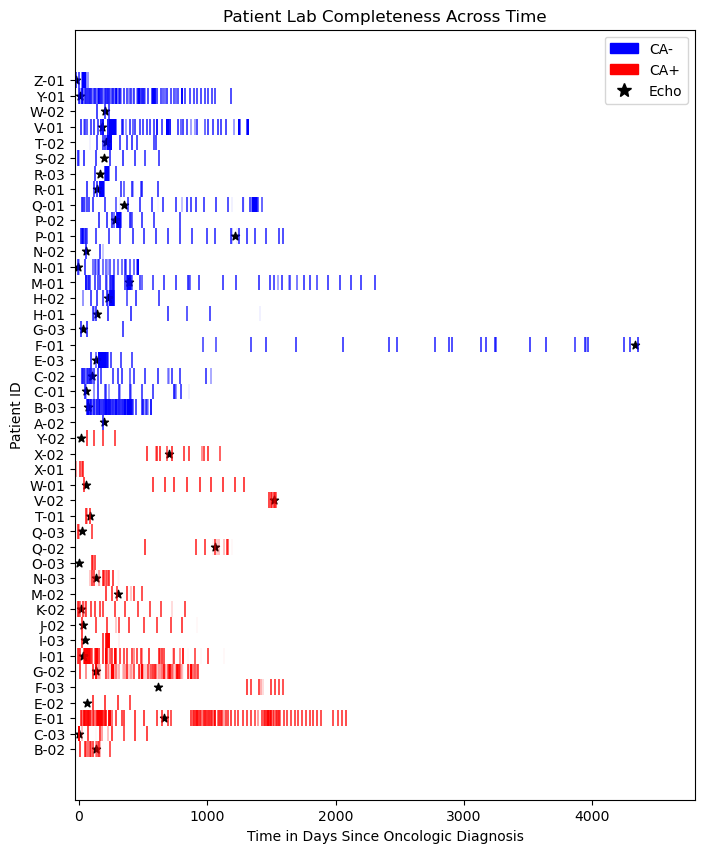

In [58]:
fig, ax = plt.subplots(figsize=(8,10))
#plot the data as an event plot
#plot the dict_time_complete_per_pt as an event plot where the listPositive are in red and the listNegative are in blue

echomarker = '*'
echomarker_color = "black"

i = 1
for pt in listPositive:
    ptLabData = ptDict[pt].labsData
    # ax.barh(y = i, width = ptDict[pt].survival*30.44, color = 'lightcoral', alpha = 1, label = 'CA+')
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'red', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

for pt in listNegative:
    ptLabData = ptDict[pt].labsData
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'blue', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

ax.set_xlim(-30,4800)
ax.set_yticks(np.arange(1, len(listKnown)+1, 1), listKnown, rotation = 'horizontal')

red_patch = mpatches.Patch(color='blue', label = 'CA-')
blue_patch = mpatches.Patch(color='red', label = 'CA+')
echomarker_line = plt.Line2D([0], [0], linestyle='none', marker=echomarker, color=echomarker_color, markersize=10, label=f'Echo')


ax.legend(handles=[red_patch, blue_patch, echomarker_line])

ax.set_title('Patient Lab Completeness Across Time')
ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
ax.set_ylabel('Patient ID')

## distribution of lab values adjacent to diagnostic imaging


In [68]:
from sklearn.preprocessing import StandardScaler
#collect the echoAdj data and apply the standard scalar

# features_ImagingAdj_df
ImagingAdj_forPlot = features_ImagingAdj_df[filteredLabs]
EchoAdj_StandardScalar = StandardScaler().fit(ImagingAdj_forPlot).transform(ImagingAdj_forPlot)
EchoAdj_StandardScalar_df = pd.DataFrame(EchoAdj_StandardScalar, index=features_ImagingAdj_df.index, columns=filteredLabs)
EchoAdj_StandardScalar_df["CA_status_yes"] = features_ImagingAdj_df["CA_status_yes"]


c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 91.7222222222222, 'Standardized Values')

c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\mcremer\.conda\envs\BEAT_Labs_20240917_v2\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


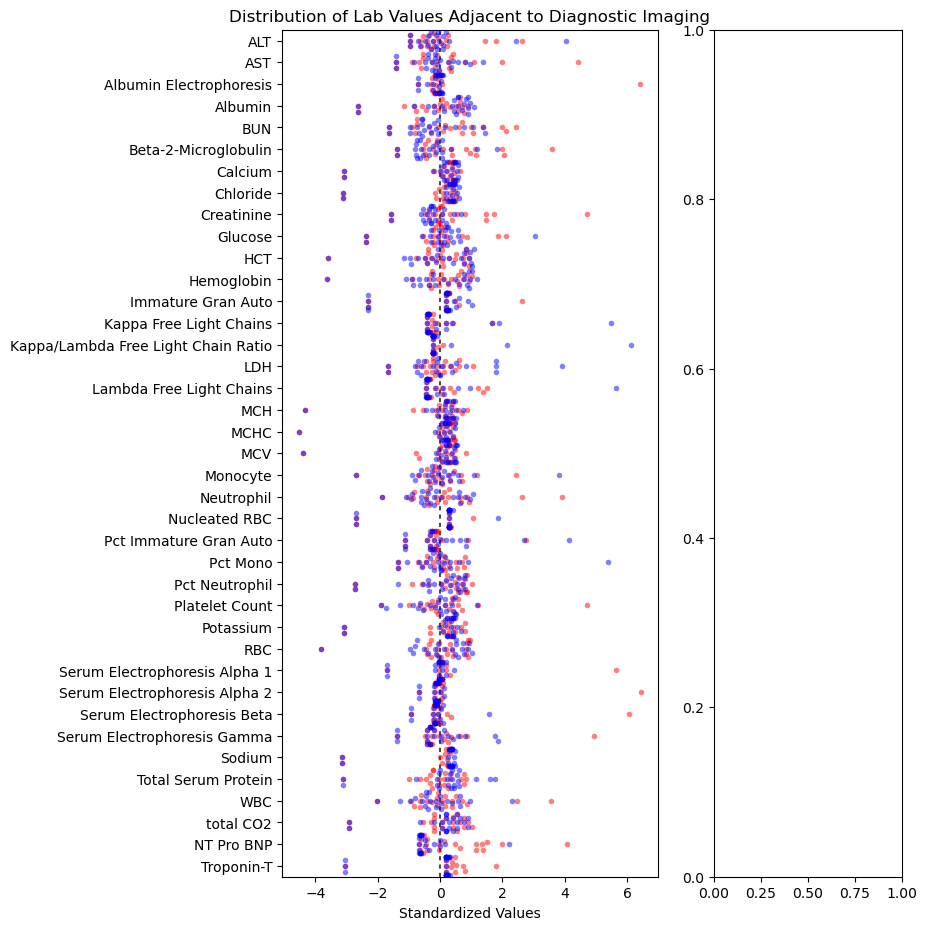

In [69]:
# Creating a two-panel figure
fig, axs = plt.subplots(1, 2, figsize=(8, 11), gridspec_kw={'width_ratios': [2, 1]})

# Left panel: Swarm plot
sns.swarmplot(EchoAdj_StandardScalar_df.drop(columns=['CA_status_yes']).loc[listPositive], 
              color='red', orient='h', size=4, alpha=0.5, ax=axs[0])
sns.swarmplot(EchoAdj_StandardScalar_df.drop(columns=['CA_status_yes']).loc[listNegative], 
              color='blue', orient='h', size=4, alpha=0.5, ax=axs[0])
axs[0].axvline(0, color=".3", dashes=(2, 2))
axs[0].set_title("Distribution of Lab Values Adjacent to Diagnostic Imaging")
axs[0].set_xlabel("Standardized Values")

In [63]:
features_ImagingAdj_df.index

Index(['A-02', 'A-03', 'B-01', 'B-02', 'B-03', 'C-01', 'C-02', 'C-03', 'D-01',
       'D-03', 'E-01', 'E-02', 'E-03', 'F-01', 'F-02', 'F-03', 'G-02', 'G-03',
       'H-01', 'H-02', 'H-03', 'I-01', 'I-02', 'I-03', 'J-02', 'J-03', 'K-02',
       'K-03', 'L-01', 'L-03', 'M-01', 'M-02', 'M-03', 'N-01', 'N-02', 'N-03',
       'O-01', 'O-02', 'O-03', 'P-01', 'P-02', 'P-03', 'Q-01', 'Q-02', 'Q-03',
       'R-01', 'R-02', 'R-03', 'S-02', 'T-01', 'T-02', 'U-01', 'U-02', 'V-01',
       'V-02', 'W-01', 'W-02', 'X-01', 'X-02', 'Y-01', 'Y-02', 'Z-01', 'Z-02'],
      dtype='object', name='DeID')

## mean lab results box plot

## plot of selected patient labs and fit of data

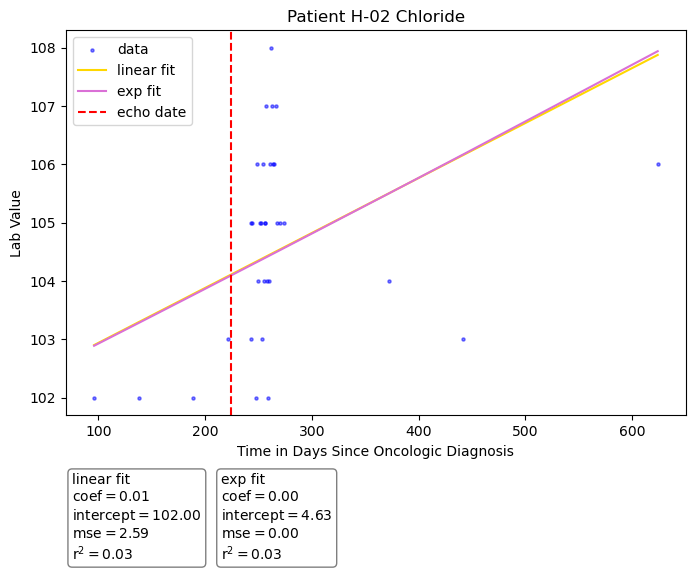

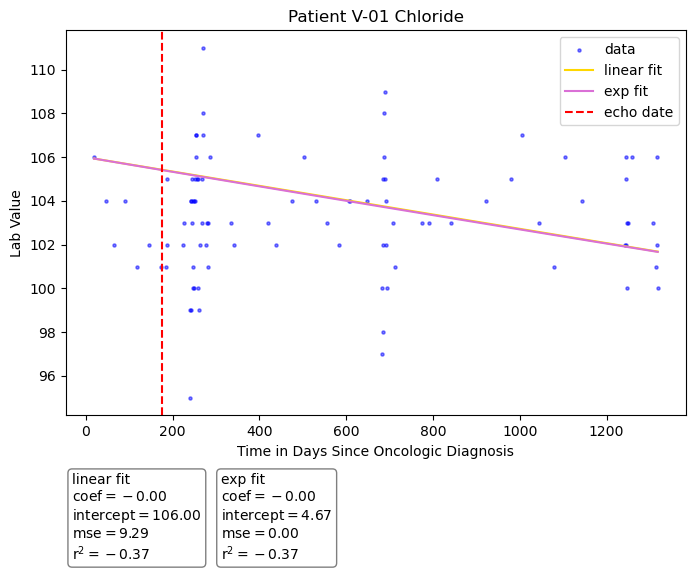

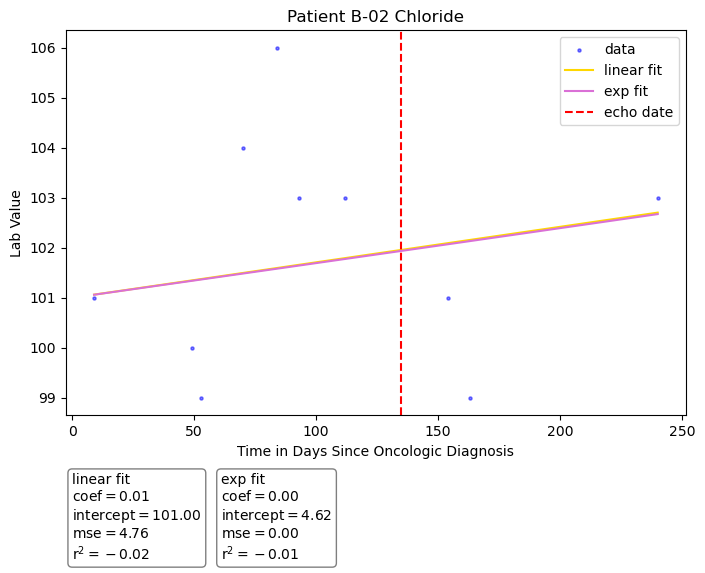

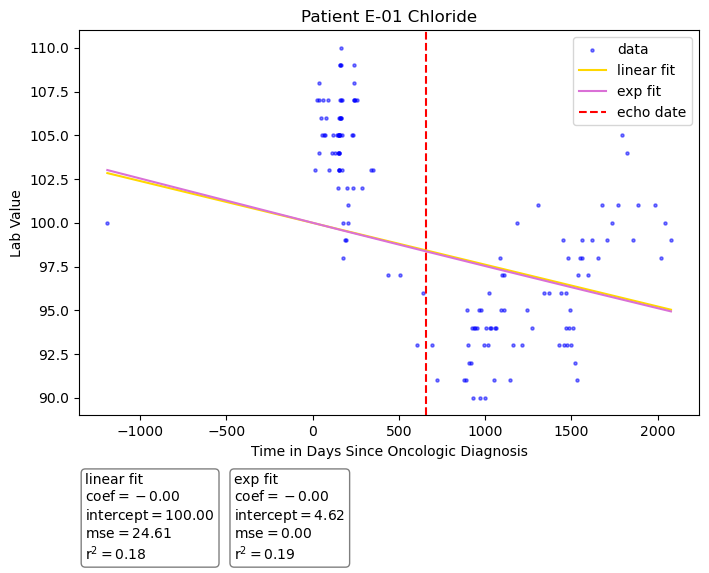

In [59]:
ptsToPlot = ['H-02', 'V-01', 'B-02', 'E-01']
lab = "Chloride"
for pt in ptsToPlot: 
    fig, ax = plt.subplots(figsize=(8,5))
    ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["none"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    #fit to the model
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    ax.scatter(x = x_values, y = y_values_shift + baseline, marker = 'o', color = 'blue', s = 5, alpha= 0.5, label = 'data')
    #plot the line where y = mx + b and m = coef, b = intercept
    ax.plot(x_values, y_prediction + intercept, color = 'gold', label = 'linear fit')

    #add textbox below legend with coef, intercept, mse, r2
    textstr = '\n'.join((
        'linear fit',
        r'$\mathrm{coef}=%.2f$' % (coef, ),
        r'$\mathrm{intercept}=%.2f$' % (intercept, ),
        r'$\mathrm{mse}=%.2f$' % (mse, ),
        r'$\mathrm{r^2}=%.2f$' % (r2, )))
    #add these patches to the figure 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.01, -0.15, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    #repeat for exponential fit on the same plot
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    #fit to the model
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    #plot the line where y = mx + b and m = coef, b = intercept
    ax.plot(x_values, np.exp(y_prediction + intercept)-1, color = 'orchid', label = 'exp fit')

    #add textbox below legend with coef, intercept, mse, r2
    textstr = '\n'.join((
        'exp fit',
        r'$\mathrm{coef}=%.2f$' % (coef, ),
        r'$\mathrm{intercept}=%.2f$' % (intercept, ),
        r'$\mathrm{mse}=%.2f$' % (mse, ),
        r'$\mathrm{r^2}=%.2f$' % (r2, )))
    #add these patches to the figure 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.25, -0.15, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)


    # add vertical line for echo date imagingAndLabDates_df.loc[pt, 'ImagingDate']
    ax.axvline(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'], color = 'red', linestyle = '--', label = 'echo date')

    #legend
    ax.legend( )
    ax.set_title(f'Patient {pt} {lab}')
    ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
    ax.set_ylabel('Lab Value')

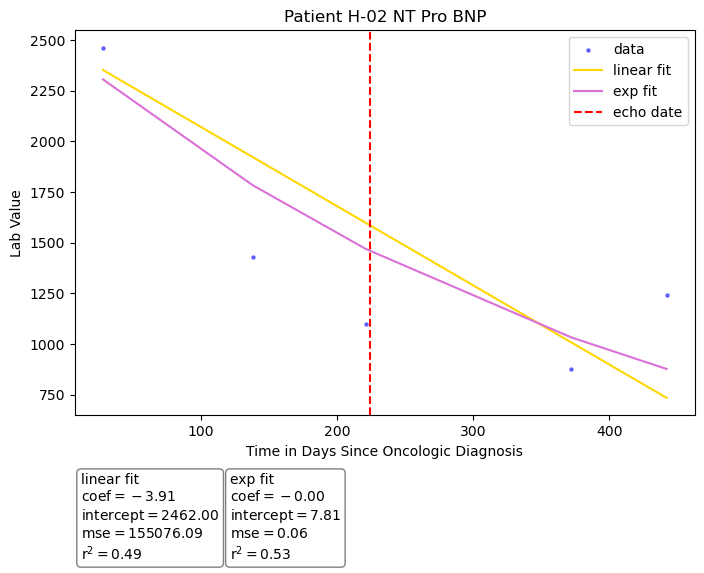

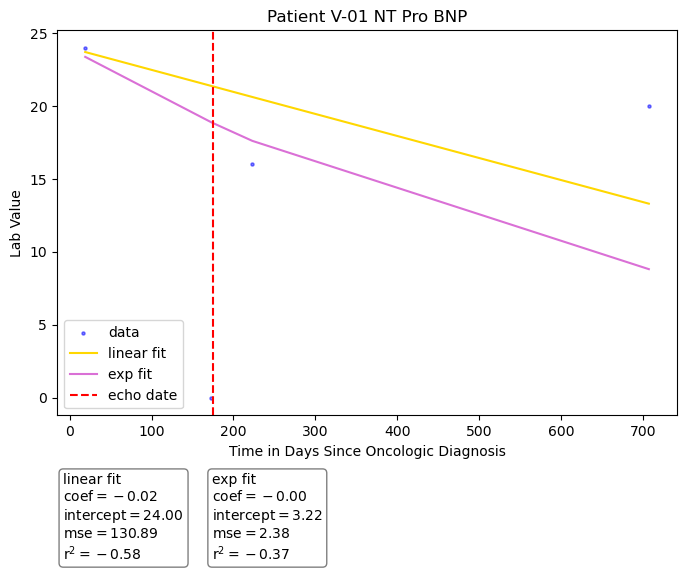

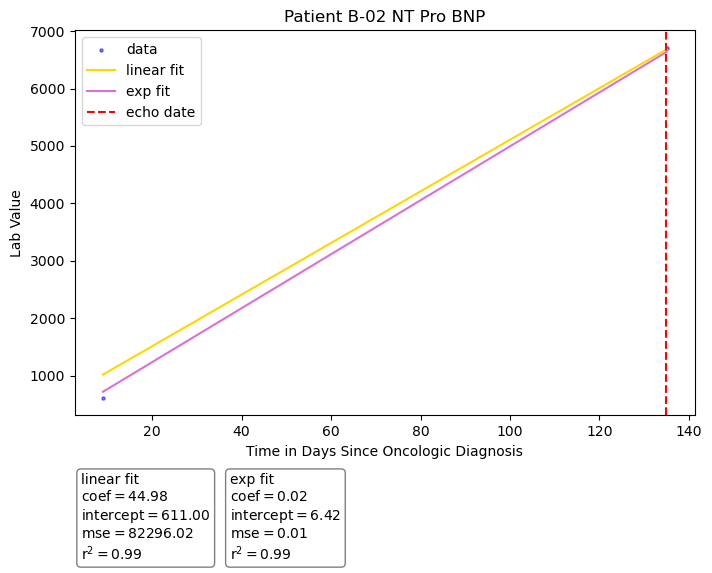

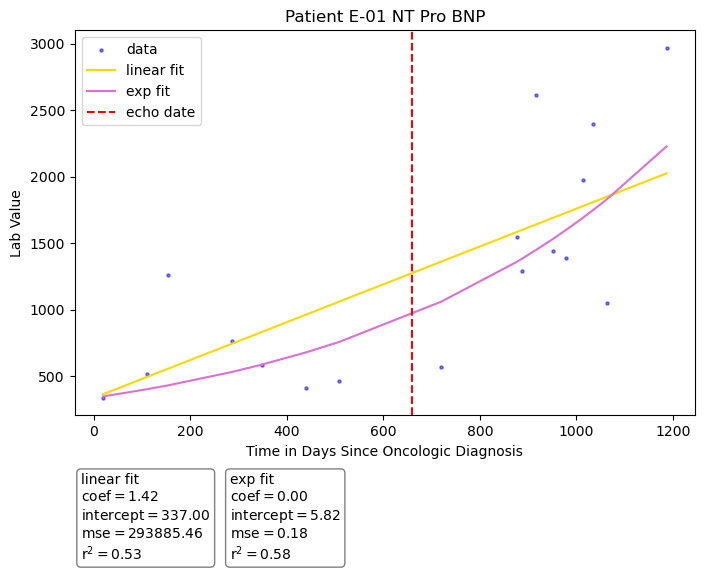

In [60]:
ptsToPlot = ['H-02', 'V-01', 'B-02', 'E-01']
lab = "NT Pro BNP"
for pt in ptsToPlot: 
    fig, ax = plt.subplots(figsize=(8,5))
    ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["none"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    #fit to the model
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    ax.scatter(x = x_values, y = y_values_shift + baseline, marker = 'o', color = 'blue', s = 5, alpha= 0.5, label = 'data')
    #plot the line where y = mx + b and m = coef, b = intercept
    ax.plot(x_values, y_prediction + intercept, color = 'gold', label = 'linear fit')

    #add textbox below legend with coef, intercept, mse, r2
    textstr = '\n'.join((
        'linear fit',
        r'$\mathrm{coef}=%.2f$' % (coef, ),
        r'$\mathrm{intercept}=%.2f$' % (intercept, ),
        r'$\mathrm{mse}=%.2f$' % (mse, ),
        r'$\mathrm{r^2}=%.2f$' % (r2, )))
    #add these patches to the figure 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.01, -0.15, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    #repeat for exponential fit on the same plot
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    #fit to the model
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    #plot the line where y = mx + b and m = coef, b = intercept
    ax.plot(x_values, np.exp(y_prediction + intercept)-1, color = 'orchid', label = 'exp fit')

    #add textbox below legend with coef, intercept, mse, r2
    textstr = '\n'.join((
        'exp fit',
        r'$\mathrm{coef}=%.2f$' % (coef, ),
        r'$\mathrm{intercept}=%.2f$' % (intercept, ),
        r'$\mathrm{mse}=%.2f$' % (mse, ),
        r'$\mathrm{r^2}=%.2f$' % (r2, )))
    #add these patches to the figure 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.25, -0.15, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)


    # add vertical line for echo date imagingAndLabDates_df.loc[pt, 'ImagingDate']
    ax.axvline(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'], color = 'red', linestyle = '--', label = 'echo date')

    #legend
    ax.legend( )
    ax.set_title(f'Patient {pt} {lab}')
    ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
    ax.set_ylabel('Lab Value')

## grid plot 43 patients for troponin

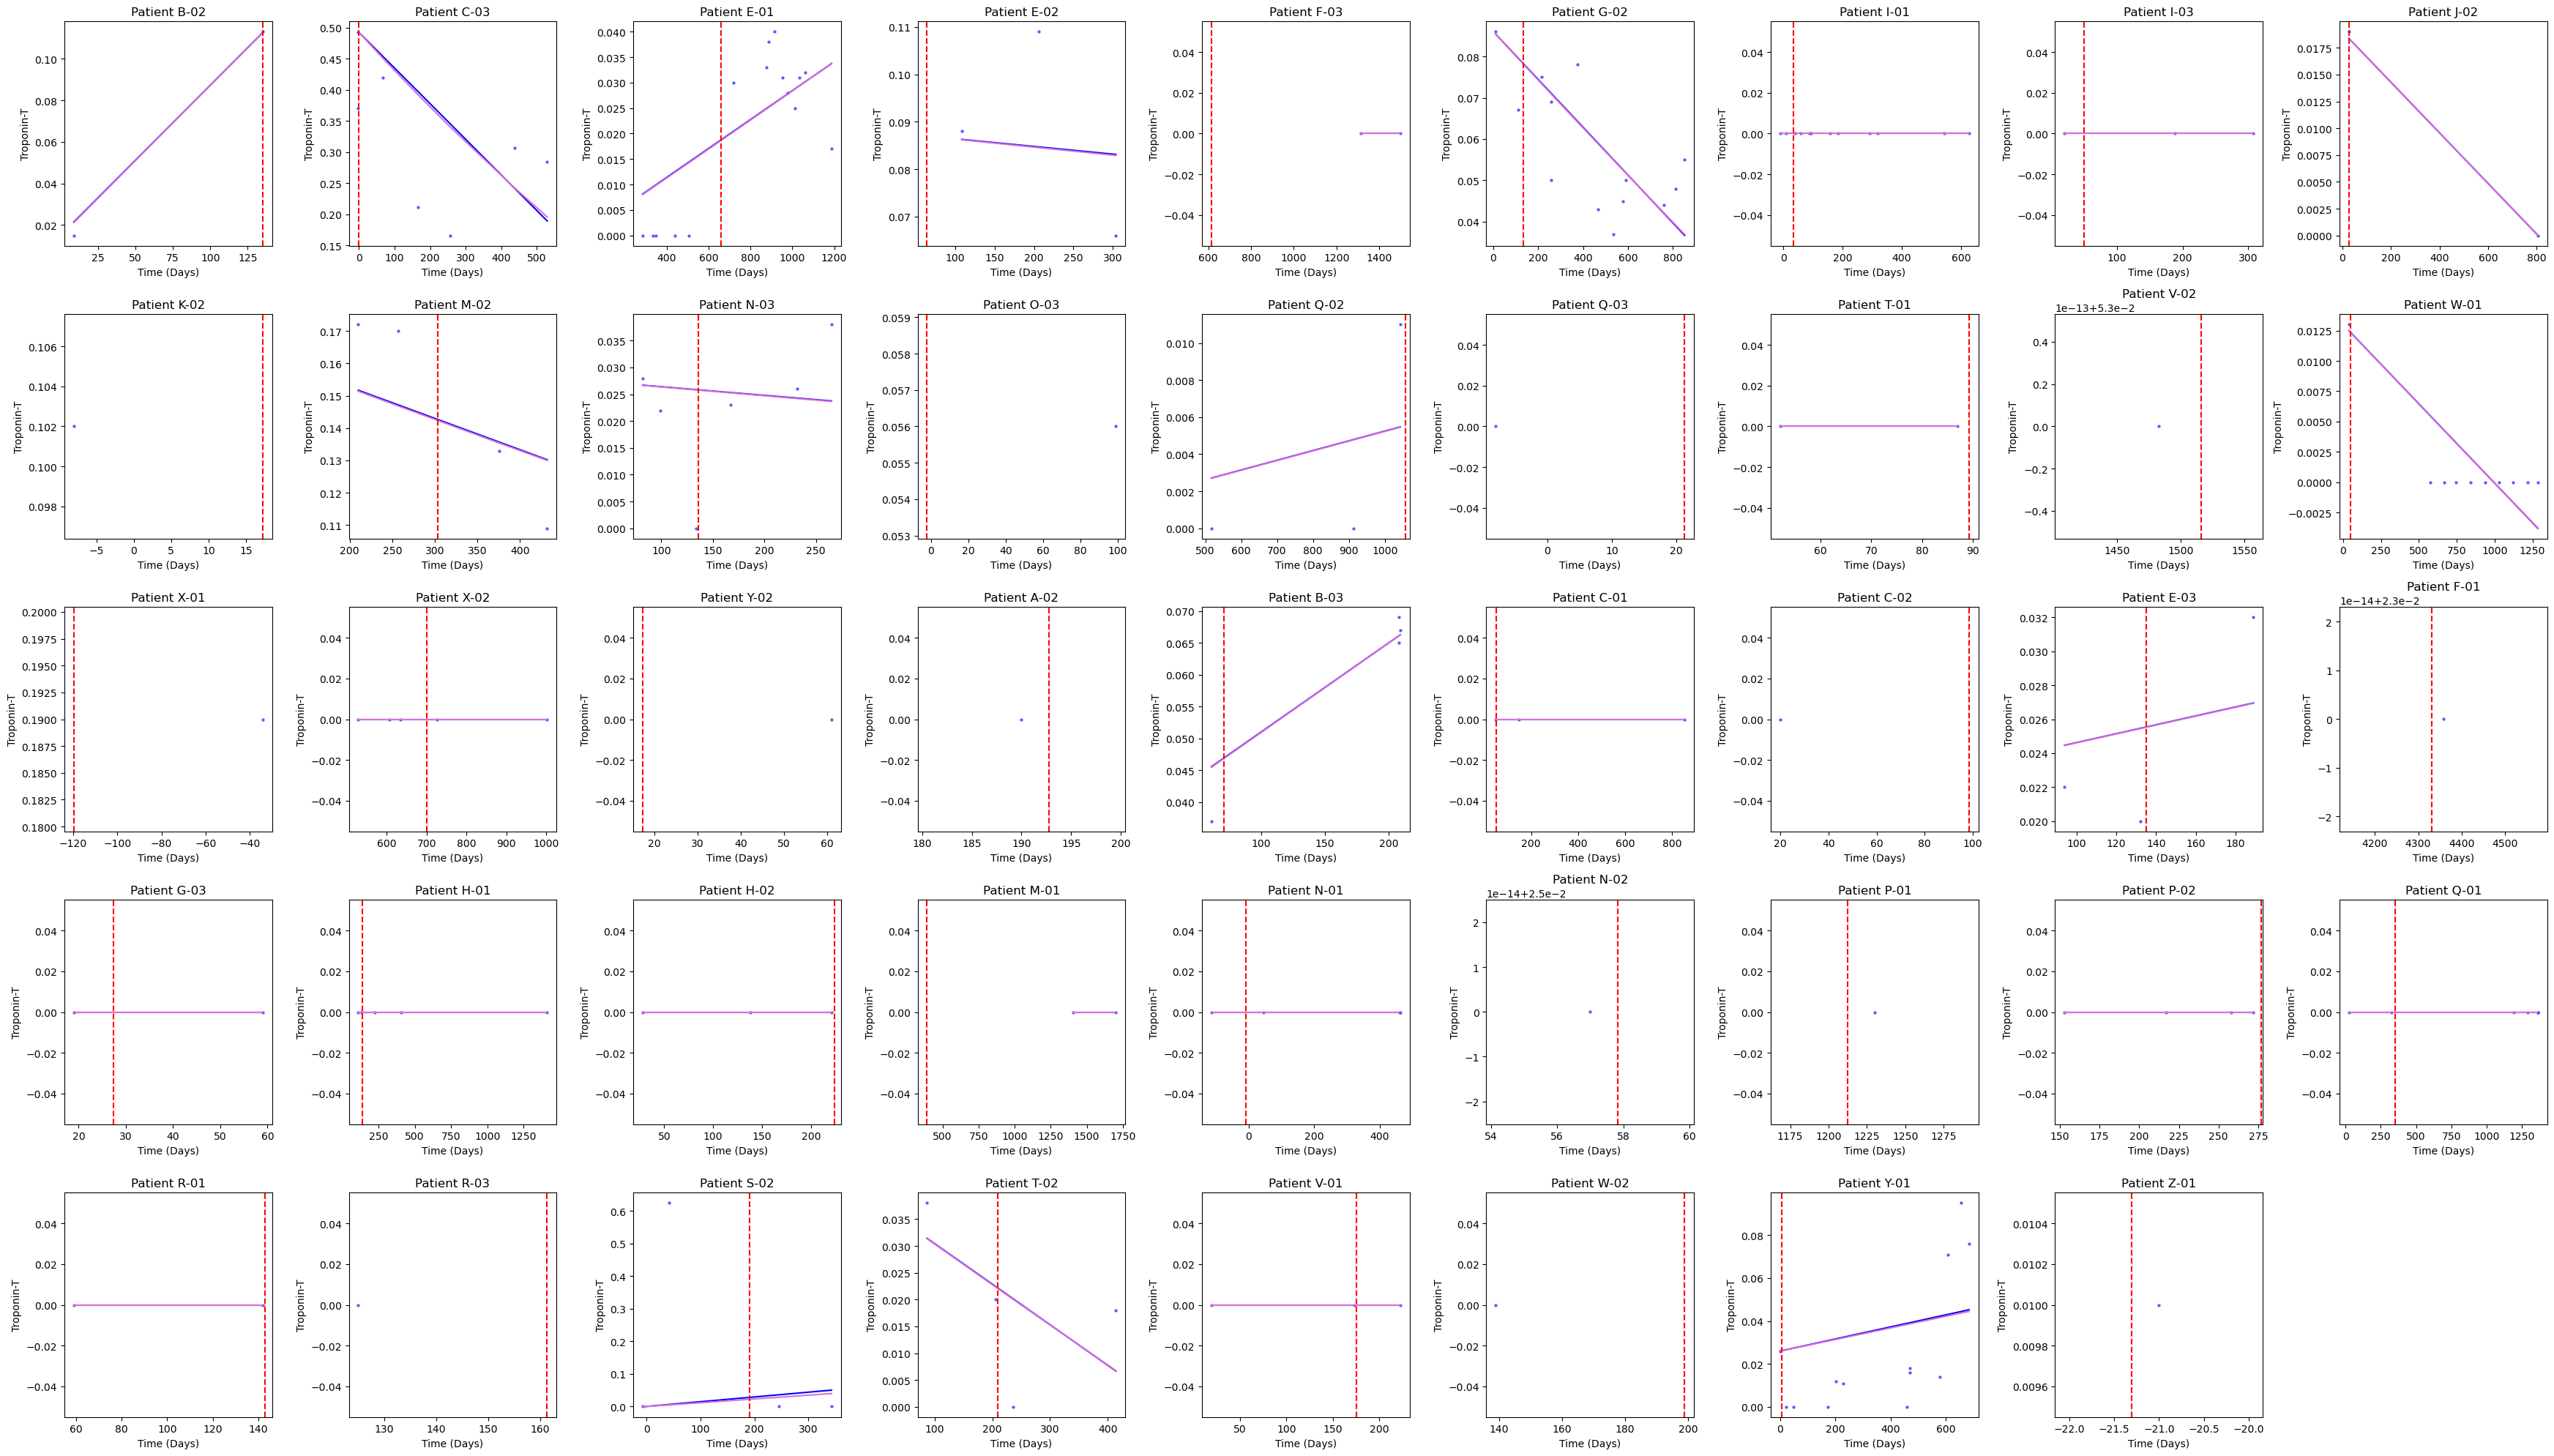

In [74]:
# Define the lab to plot
lab = "Troponin-T"

# Set up the grid of subplots
num_patients = len(listKnown)
cols = 9  # Number of columns in the grid
rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each patient and plot their data
for i, pt in enumerate(listKnown):
    ax = axes[i]
    ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
    
    # Prepare data for linear fit
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform=["none"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    
    #scatter plot of the original data
    ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')

    # Perform linear fit
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
    ax.plot(x_values, y_prediction + intercept, color='blue', label='linear fit')
    
    # Prepare data for exponential fit
    x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform=["ln"])
    x_values_flat = x_values.squeeze()
    y_values_shift_flat = y_values_shift.squeeze()
    
    # Perform exponential fit
    coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
    ax.plot(x_values, np.exp(y_prediction + intercept) - 1, color='orchid', label='exp fit')
    
    # Add vertical line for echo date
    ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
    
    # Set title and labels
    ax.set_title(f'Patient {pt}')
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Troponin-T')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()